# Load the dataset


In [ ]:
# Setting up google drive 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')

Mounted at /content/gdrive


In [ ]:
import my_utils as mu
import torch
from torch import nn
from IPython import display
import numpy as np
import matplotlib.pyplot as plt

Load the fashion MNIST dataset

Set batch size to 256

In [ ]:
batch_size = 256
train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Prepare the training set and visualize one image and a label. There are 10 classes in the dataset, and the labels for each class are :

0	T-shirt/top

1	Trouser

2	Pullover

3	Dress

4	Coat

5	Sandal

6	Shirt

7	Sneaker

8	Bag

9	Ankle boot

One of the image and its label is visualized here to confirm the data is loaded correctly.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


image shape: torch.Size([256, 1, 28, 28])
label:5


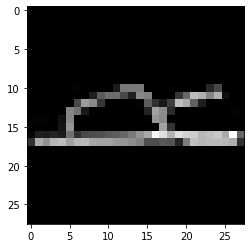

In [ ]:
train = next(iter(train_iter))
x, y = train
print(f"image shape: {x.shape}")
plt.imshow(x[0].squeeze(), cmap="gray")
print(f"label:{y[0]}")

# The stem (Get patches)

All the images have size of 28*28. We use 2 or 4 to be patch sizes.

The stride is set to the same number as the patch sizes because we are getting non-overlapping patches.We use torch.Tensor.unfold (https://pytorch.org/docs/stable/generated/torch.Tensor.unfold.html) to do this.

In [ ]:
def get_patch(x):
  batch_size = x.shape[0]
  n_channels = x.shape[1]

  kh, kw = 2, 2
  dh, dw = 2, 2 

  # unfold the 2nd and 3rd dimensions from torch.Size([256, 1, 28, 28])
  # unfold(index, kernel size, stride)
  patches = x.unfold(2, kh, dh).unfold(3, kw, dw)
  unfold_shape = patches.size()

  patches_orig = patches.view(unfold_shape)
  patches = patches.contiguous().view(batch_size, n_channels, -1, kh, kw)

  return patches

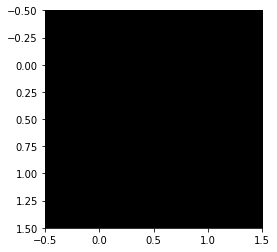

In [ ]:
# Visualize one of the patches
# patches[batch size -> first image][iter channel][patch number(0~3)]
plt.imshow(patches[0][0][1], cmap="gray")

# The model

Instead of using CNN, we are creating the model manually by adding MLPs and other components.

The model consists three main parts, namely stem, backbone, and classifier. 

The stem step was mostly done in the get_patch function, so we only apply $f$, a linear layer. The backcone contains 2 blocks, and there are 2 MLPs in each block. The classifier takes the output of the last hidden layer as input. The classifier here is another linear layer. 

The hidden size used  in the backbone are between 16 and 196.

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, num_outputs):
        super(Net, self).__init__()
        # Input patch size and number of patches
        self.kh, self.kw = 2, 2
        self.num_patches = 196
        self.num_inputs = self.kh * self.kw
        self.get_patch = get_patch

        # Hidden layers
        self.num_hidden1 = 196
        self.num_hidden2 = 100
        self.num_hidden3 = 196
        self.num_hidden4 = 64
        self.num_hidden5 = 196
        self.num_hidden6 = 32
        self.num_hidden7 = 196
        self.num_hidden8 = 64
        self.num_hidden9 = 16

        # Output
        self.num_outputs = num_outputs

        # Batch normalization
        self.batchnorm = nn.BatchNorm1d(self.num_hidden1)

        # Stem
        self.stem = nn.Linear(self.num_inputs,self.num_hidden1)

        # First block
        self.linear1 =  nn.Linear(self.num_hidden1, self.num_hidden2)
        self.linear2 = nn.Linear(self.num_hidden2, self.num_hidden3)
        self.linear3 = nn.Linear(self.num_hidden3,self.num_hidden4)
        self.linear4 = nn.Linear(self.num_hidden4, self.num_hidden5)

        # Second block
        self.linear5 = nn.Linear(self.num_hidden5, self.num_hidden6)
        self.linear6 = nn.Linear(self.num_hidden6, self.num_hidden7)
        self.linear7 = nn.Linear(self.num_hidden7, self.num_hidden8)
        self.linear8 = nn.Linear(self.num_hidden8, self.num_hidden9)

        # Non-linear activation function
        self.relu = nn.ReLU()
        # Dropout
        self.dropout = nn.Dropout(p=0.2)
        # Classifier
        self.classifier = nn.Linear(self.num_hidden9, self.num_outputs)


    def forward(self, x):
        # Get patches
        x = self.get_patch(x)
        x = x.view(x.shape[0], -1, self.kh, self.kw)
        x = x.view(x.shape[0], -1, self.kh * self.kw)
        
        x = self.stem(x)
        x = self.relu(x)

        # First block
        x = torch.transpose(x,1,2)
        x = self.linear1(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        x = self.linear2(x)

        x = torch.transpose(x,1,2)
        x = self.dropout(x)

        x = self.linear3(x)
        x = self.relu(x)
        x = self.linear4(x)

        # Secoond block
        x = torch.transpose(x,1,2)
        x = self.linear5(x)
        x = self.relu(x)
        x = self.linear6(x)
        x = torch.transpose(x,1,2)
        x = self.dropout(x)
        x = self.linear7(x)
        x = self.relu(x)
        x = self.linear8(x)

        # Get mean of the features
        x = torch.mean(x,1)
        out = self.classifier(x)

        return out

num_outputs = 10
net = Net(num_outputs)
print(net)
net(x)

Net(
  (batchnorm): BatchNorm1d(196, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (stem): Linear(in_features=4, out_features=196, bias=True)
  (linear1): Linear(in_features=196, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=196, bias=True)
  (linear3): Linear(in_features=196, out_features=64, bias=True)
  (linear4): Linear(in_features=64, out_features=196, bias=True)
  (linear5): Linear(in_features=196, out_features=32, bias=True)
  (linear6): Linear(in_features=32, out_features=196, bias=True)
  (linear7): Linear(in_features=196, out_features=64, bias=True)
  (linear8): Linear(in_features=64, out_features=16, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (classifier): Linear(in_features=16, out_features=10, bias=True)
)


tensor([[-0.1836,  0.1515,  0.0718,  ...,  0.2838,  0.0475,  0.0745],
        [-0.1831,  0.1520,  0.0724,  ...,  0.2839,  0.0475,  0.0735],
        [-0.1832,  0.1518,  0.0725,  ...,  0.2839,  0.0474,  0.0734],
        ...,
        [-0.1843,  0.1516,  0.0725,  ...,  0.2840,  0.0480,  0.0747],
        [-0.1842,  0.1522,  0.0723,  ...,  0.2839,  0.0487,  0.0745],
        [-0.1842,  0.1525,  0.0720,  ...,  0.2837,  0.0477,  0.0742]],
       grad_fn=<AddmmBackward0>)

Using xavier_uniform to initialize weights.

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear): 
        torch.nn.init.xavier_uniform(m.weight)

net.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Net(
  (batchnorm): BatchNorm1d(196, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (stem): Linear(in_features=4, out_features=196, bias=True)
  (linear1): Linear(in_features=196, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=196, bias=True)
  (linear3): Linear(in_features=196, out_features=64, bias=True)
  (linear4): Linear(in_features=64, out_features=196, bias=True)
  (linear5): Linear(in_features=196, out_features=32, bias=True)
  (linear6): Linear(in_features=32, out_features=196, bias=True)
  (linear7): Linear(in_features=196, out_features=64, bias=True)
  (linear8): Linear(in_features=64, out_features=16, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (classifier): Linear(in_features=16, out_features=10, bias=True)
)

Getting loss function and optimizer, and learning rate scheduler(https://www.geeksforgeeks.org/adjusting-learning-rate-of-a-neural-network-in-pytorch/)


Using learning rate scheduler here to adjust learning rate during training. ReduceLROnPlateau is used here and the mode is 'max', patience is 15. The 'max' mode means the learning rate changes when the accuracy does not increase. The patience means after a certain number of epochs, if the matrics does not improve, the learning rate is adjusted. 

In [ ]:
loss = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(net.parameters(),lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=15)

Define the accuracy function.

In [ ]:
def accuracy(y_hat, y):  #y_hat is a matrix; 2nd dimension stores prediction scores for each class.
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # Predicted class is the index of max score         
    cmp = (y_hat.type(y.dtype) == y)  # because`==` is sensitive to data types
    return float(torch.sum(cmp)) # Taking the sum yields the number of correct predictions.

y_hat = net(x)
accuracy(y_hat, y) / len(y)

0.08203125

Define functions including animator for the graph, training epochs, and evaluation.

In [ ]:
class Accumulator:  
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n # [0, 0, ..., 0]
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

def evaluate_accuracy(net, data_iter): 
    """Compute the accuracy for a model on a dataset."""
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    net.eval()
    for _, (X, y) in enumerate(data_iter):
        if torch.cuda.is_available():
          X, y = X.cuda(), y.cuda()
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def train_epoch_ch3(net, train_iter, loss, optimizer, batch_size=256, num_outputs=10):  
    """The training function for one epoch."""
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        if torch.cuda.is_available():
          X, y = X.cuda(), y.cuda()
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)

        optimizer.zero_grad()
        l.backward()
        optimizer.step()
      
        metric.add(float(l) * len(y), accuracy(y_hat, y), y.size().numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]


class Animator:  
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        mu.use_svg_display()
        self.fig, self.axes = mu.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: mu.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

def train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer): 
    """Train a model."""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.1, 1.0],
                        legend=['train loss', 'train acc', 'test acc'])
    lrs=[]
    cur_ep=0
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, optimizer)
        test_acc = evaluate_accuracy(net, test_iter)
        scheduler.step(test_acc)
        animator.add(epoch + 1, train_metrics + (test_acc,))
        train_loss, train_acc = train_metrics
        learning_r = optimizer.param_groups[0]['lr']
        lrs.append((learning_r,epoch))
        cur_ep+=1
        print(f"training loss: {train_loss}, training accuracy: {train_acc}, test accuracy: {test_acc}, learning rate:{learning_r}, epoch:{epoch}")


        if test_acc >= 0.9:
          print(f"You got a {test_acc}!")
          break

          
    train_loss, train_acc = train_metrics
    print(f"training loss: {train_loss}, training accuracy: {train_acc}, test accuracy: {test_acc}")
    print(f"learning rates:{lrs}")


Allocate the model to cuda if it is available.

In [ ]:
if torch.cuda.is_available():
  net = net.cuda()

## Train and plot to see the accuracy

training loss: 0.1737744316895803, training accuracy: 0.9353666666666667, test accuracy: 0.9042, learning rate:0.001, epoch:23
You got a 0.9042!
training loss: 0.1737744316895803, training accuracy: 0.9353666666666667, test accuracy: 0.9042
learning rates:[(0.001, 0), (0.001, 1), (0.001, 2), (0.001, 3), (0.001, 4), (0.001, 5), (0.001, 6), (0.001, 7), (0.001, 8), (0.001, 9), (0.001, 10), (0.001, 11), (0.001, 12), (0.001, 13), (0.001, 14), (0.001, 15), (0.001, 16), (0.001, 17), (0.001, 18), (0.001, 19), (0.001, 20), (0.001, 21), (0.001, 22), (0.001, 23)]


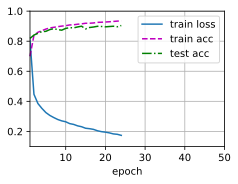

In [ ]:
num_epochs = 50
train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer)

## Save the model

In [ ]:
PATH = 'nn_dl_model.pt'
torch.save(net.state_dict(), PATH)

## Reference

https://huggingface.co/datasets/fashion_mnist

https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html#torch.optim.lr_scheduler.ReduceLROnPlateau

https://pytorch.org/docs/stable/generated/torch.cuda.is_available.html

https://pytorch.org/docs/stable/generated/torch.save.html?highlight=save#torch.save

https://pytorch.org/docs/stable/generated/torch.Tensor.unfold.html)